In [1]:
import tweepy
import twint
import nltk
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
from nltk.stem import Cistem
#from nltk.stem.snowball import GermanStemmer
from nltk.tokenize import TweetTokenizer
#import re
import regex as re
import emoji
import datetime
import glob
import io
import os
import random
import string
import unicodedata
import time
import sys
import pandas as pd
import numpy as np
from scipy import stats
import sklearn
from sklearn.preprocessing import QuantileTransformer
from sklearn.mixture import GaussianMixture as GMM
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from pprint import pprint

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import tqdm

# Workaround for Jupyter's "This event loop is already running" exception
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Check for GPU availability
if tf.test.gpu_device_name():
    print(tf.test.gpu_device_name())
    print("GPU available.")
else:
    print("GPU not available.")
    
# Print numpy version
print(np.__version__) ## For LSTM layers to work, numpy must be version 1.19.5 for some reason

tweets = None

/device:GPU:0
GPU available.
1.19.5


In [ ]:
nltk.download('stopwords')


# Class Miner

In [3]:
class Miner(object):
    result_limit = 100
    data         = []
    api          = False
    seed         = 42
    
    twitter_keys = {
        'consumer_key':        'YOUR_CONSUMER_KEY_HERE',
        'consumer_secret':     'YOUR_CONSUMER_SECRET_HERE',
        'access_token':        'YOUR_ACCESS_TOKEN_HERE',
        'access_token_secret': 'YOUR_ACCESS_TOKEN_SECRET_HERE'
    }

    def __init__(self, keys_dict=twitter_keys, api=api, result_limit=20):
        self.twitter_keys = keys_dict
        
        auth = tweepy.OAuthHandler(keys_dict['consumer_key'], keys_dict['consumer_secret'])
        auth.set_access_token(keys_dict['access_token'], keys_dict['access_token_secret'])
        
        self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        #self.api = tweepy.API(auth, wait_on_rate_limit=False, wait_on_rate_limit_notify=False)
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit
    
    def openIds(self, handle="gecko203"):
        return pd.read_csv("{}/{}_ids.csv".format(handle, handle), encoding='utf-8')
    
    def openFollowers(self, handle="gecko203"):
        return pd.read_csv("{}/{}_follower_ids.csv".format(handle, handle), encoding='utf-8')
    
    def openFollowing(self, handle="gecko203"):
        return pd.read_csv("{}/{}_following_ids.csv".format(handle, handle), encoding='utf-8')
    
    def openFriends(self, handle="gecko203"):
        return pd.read_csv("{}/{}_friends_ids.csv".format(handle, handle), encoding='utf-8')

    def openCSVs(self, handle="gecko203"):
        files = glob.glob("{}/tweets/*.csv".format(handle))
        print("Opening {} CSV files.".format(len(files)))
        return pd.concat([pd.read_csv(f, encoding='utf-8') for f in files])
        
    
    def get_user_id(self, handle='gecko203'):
        return self.api.get_user(screen_name=handle).id
    
    def get_user_by_id(self, userid=0):
        return self.api.get_user(id=userid)
    
    def get_relationships(self, user="gecko203"):
        follower_ids  = self.api.followers_ids(screen_name=user)
        following_ids = self.api.friends_ids(screen_name=user)
        friends_ids   = list(set(follower_ids).intersection(set(following_ids)))
        
        df = pd.DataFrame(follower_ids)
        df.to_csv('{}/{}_follower_ids.csv'.format(user, user), encoding='utf-8', line_terminator='\r\n', index=False)
        df = pd.DataFrame(following_ids)
        df.to_csv('{}/{}_following_ids.csv'.format(user, user), encoding='utf-8', line_terminator='\r\n', index=False)
        df = pd.DataFrame(friends_ids)
        df.to_csv('{}/{}_friends_ids.csv'.format(user, user), encoding='utf-8', line_terminator='\r\n', index=False)
        
        return follower_ids, following_ids, friends_ids
    
    def get_relationships_snd(self, user="gecko203", max_following=1000, max_fss=1000):
        _, _, friends_ids = self.get_relationships(user=user)
        
        fss = {}
        
        for i in friends_ids:
            # TODO: Skip Accounts with too many friends.
            friends_following_count = 0
            try:
                friends_following_count = self.api.get_user(user_id=i).friends_count
            except:
                continue
                
            if(friends_following_count == 0 or friends_following_count > max_following):
                continue
            try:
                newFriends = list(set(self.api.followers_ids(user_id=i)).intersection(set(self.api.friends_ids(user_id=i))))
                fss[i] = newFriends
            except:
                continue
            if(len(fss) >= max_fss):
                break
        
        return fss
    
    def testfollowers(self):
        follower_ids, following_ids, friends_ids = self.get_relationships(user="FiatPecunia")
        #loc = [self.api.get_u
        loc = {i:self.api.get_user(i).followers_count for i in follower_ids}
        return loc
    
    def get_user_tweets_by_id(self, roothandle="FiatPecunia",
                              userid=0,
                              get_retweets=True,
                              get_replies=False,
                              max_count=3200):
        #data = []
        #for tweet in tweepy.Cursor(self.api.user_timeline,
        #                           user_id=userid,
        #                           #count=self.result_limit, # Results per page
        #                           count=900,
        #                           tweet_mode='extended',
        #                           exclude_replies=not get_replies,
        #                           include_retweets=get_retweets
        #                           ).items(max_count):
        #    # Do Stuff
        #    #TODO: Filter out RTs if include_retweets == False since
        #    #      the parameter doesn't work in tweepy 3.10
        #    if(tweet.full_text.startswith('RT')):
        #        continue
        #    mined = {
        #        'tweet_id': tweet.id,
        #        'author_id': tweet.user.id,
        #        'text': tweet.full_text,
        #        'lang': tweet.lang,
        #        'favourite_count': tweet.favorite_count,
        #        'retweet_count': tweet.retweet_count,
        #        'retweeted_by': self.api.retweeters(id=tweet.id) #count=100),
        #        #'quote_count': tweet.quote_count, Only available with Premium
        #        #'reply_count': tweet.reply_count, Only available with Premium
        #        'hashtags': [hs['text'] for hs in tweet.entities['hashtags']], #tweet.entities['hashtags']
        #        'mined_at': datetime.datetime.now(),
        #        'created_at': tweet.created_at
        #    }
        #    try:
        #        mined['media_count'] = len(tweet.entities['media'])
        #    except:
        #        mined['media_count'] = 0
        #    data.append(mined)
        c = twint.Config()
        c.User_id = str(userid)
        c.Lang = "de"
        c.Output = "{}/tweets/{}.csv".format(roothandle, userid)
        c.Until = (datetime.datetime.now() - datetime.timedelta(days=2)).strftime('%Y-%m-%d')
        c.Store_csv = True
        c.Limit = max_count
        c.Retweets = False
        c.Filter_retweets = True
        c.Stats = False
        c.Show_hashtags = False
        c.Hide_output = True
        
        twint.run.Search(c)
        
        #return data
    
    def getFollowerCount(self, it):
            try:
                return self.api.get_user(it).followers_count
            except:
                # Skip this user and remove it from the tweets by setting
                # this user's follower count to 0 and remove all those later
                return 0
    
    # Metrics
    #def rateTweet(self, tweet, nFollowers=0, nFollowing=0, nFriends=0):
    def rateTweet(self, tweet, friends, following, followers_count):
        # TODO: Somehow retrieve data for following_rt and friends_rt?
        rating = 0.0
            
            
        # Increase the rating if a retweet comes from somebody in the bubble
        # i.e. in the "friends" file.
            
        # If one of my own followers retweeted this tweet, give some extra points
            
        # If somebody I follow retweeted this tweet, give some extra points
            
        # If one of my own friends retweeted this tweet, give double the extra points
        
            
        
        #author_id = tweet.author_id
        
    
        likes_to_followers = tweet.likes_count / followers_count
        #likes_to_followers = tweet.likes_count_boxcox / followers_count
        #likes_to_following = tweet.likes_count / following_count
        #likes_to_friends   = tweet.likes_count / friends_count
            
        rts_to_followers   = tweet.retweets_count / followers_count
        #rts_to_followers = tweet.retweets_count_boxcox / followers_count
            
        #following_rt = 0
        #friends_rt   = 0
            
        #rating  = likes_to_followers + 4*(rts_to_followers)
        ## Give some extra points if the tweet's author is the user's friend or the user follows the author.
        #if(tweet.user_id in friends):
        #    rating = rating * 4
        #elif(tweet.user_id in following):
        #    rating = rating * 2
        ## Push "good" tweets in "absolute" scales to the right on the logarithm.
        #rating += followers_count + tweet.likes_count + 1*tweet.retweets_count
        #    
        #rating = np.log(rating)
        rating = likes_to_followers + 4*(rts_to_followers)
        if(tweet.user_id in friends):
            rating = rating * 4
        elif(tweet.user_id in following):
            rating = rating * 2
        
        #rating += 1
        #rating = np.log(rating)
    
        return rating
    
    def rateTweets(self, root_handle='gecko203', tweets=None):
        friends = self.openFriends(root_handle)
        following = self.openFollowing(root_handle)
        #follower_ids, following_ids, friends_ids = self.get_relationships(user=root_handle)
        
        # DataFrame storing the results
        if(tweets is None):
            results = self.openCSVs()
        else:
            results = tweets
        
        # Get the set of all authors and create a dictionary with their ids as keys and
        # their follower count as values.
        #author_ids = set(tweets['user_id'].unique())
        author_ids = set(results['user_id'].unique())
        author_dict = {i:self.getFollowerCount(i) for i in author_ids}
        #try:
        #    #author_dict = {i:self.api.get_user(i).followers_count for i in author_ids}
        #except:
        #    # TODO: Wrap self.api.get_user(i) in a utility function
        #    # so that exceptions can be handled.
        #    # https://www.geeksforgeeks.org/how-to-handle-a-python-exception-in-a-list-comprehension/
        #    pass

        # Drop all entries with followercount = 0
        for i, c in author_dict.items():
            if c == 0:
                index_id = results[results['user_id'] == i].index
                results.drop(index_id, inplace=True)

        # Add a new column
        results.insert(1, 'rating', 0.0, True)

#        testTweet = results.iloc[0]
        #for i in range(len(results)):
        for i, row in results.iterrows():
            t = results.iloc[i]
            #results.iloc[i].rating = self.rateTweet(t, 
            #results.at[i, 'rating'] = self.rateTweet(t,
            #                                         nFollowers=len(follower_ids),
            #                                         nFollowing=len(following_ids),
            #                                         nFriends=len(friends_ids))
            results.at[i, 'rating'] = self.rateTweet(t,
                                                     friends,
                                                     following,
                                                     author_dict[t.user_id])
        
        # Apply a QuantileTransformation on the data so that it approximates a normal distribution.
        print("Performing quantile transformation on ratings...")
        qt = QuantileTransformer(n_quantiles=len(results['rating'])-int(len(results['rating'])/2),
                                 subsample=1e7,
                                 #output_distribution='uniform')
                                 output_distribution='normal')
        data = results['rating'].to_numpy().reshape((len(results), 1))
        data = qt.fit_transform(data)
        data = pd.DataFrame(data)
        data = list(data[0])
        
        #results['rating'] = qt.fit_transform(results['rating'])
        results['rating'] = data
        print("Done.")
        
        # Standardize the ratings.
        mean_rating = results['rating'].mean()
        std_rating  = results['rating'].std()
        for i, row in results.iterrows():
            results.at[i, 'rating'] = (row.rating - mean_rating) / std_rating
        
        # Normalize the ratings so that they are between 0 and 1.
        # TODO: -1 and 1
        max_rating = results['rating'].max()
        min_rating = results['rating'].min()
        #for i in range(len(results)):
        #    results.iloc[i].rating = (results.iloc[i].rating - min_rating)/(max_rating - min_rating)
        for i, row in results.iterrows():
            #results.at[i, 'rating'] = (results.iloc[i].rating - min_rating)/(max_rating - min_rating)
            results.at[i, 'rating'] = (row.rating - min_rating)/(max_rating - min_rating)

    
        return results
    
    def preprocess(self, handle='gecko203', visualize=False):
        tweets = self.openCSVs(handle=handle)
        print("Done.")
        # Filter out all replies
        print("Removing replies...")
        tweets = tweets[tweets['reply_to'].apply(len).lt(3)]
        print("Done.")
        # Filter out all non-German tweets
        print("Removing all non-German tweets...")
        tweets = tweets[tweets['language'] == 'de']
        print("Done.")
        # Drop unneeded columns
        print("Dropping unneeded columns...")
        tweets.drop(columns=['conversation_id', 'date', 'time', 'timezone', 'place', 'mentions', 'urls', 
                     'link', 'retweet', 'quote_url', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id',
                     'user_rt', 'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src', 'trans_dest',
                     'language', 'created_at',
                     'username', 'name'
                     ], inplace=True)
        print("Done.")
        # Does the tweet contain a photo?
        print("Checking if tweets contain photos...")
        tweets['photos'] = tweets['photos'].apply(lambda p: not (p == "[]"))
        print("Done.")
        # Rescale log normal distributed columns by running transformations on them (boxcox, ...)
        # All data must have values > 0 for boxcox to work.
        #print("Boxcox-transforming replies, retweets, likes...")
        #tweets['replies_count'] = tweets['replies_count'].apply(lambda x: x + 1)
        #tweets['retweets_count'] = tweets['retweets_count'].apply(lambda x: x + 1)
        #tweets['likes_count'] = tweets['likes_count'].apply(lambda x: x + 1)
        
        #tweets['replies_count'] = stats.boxcox(tweets['replies_count'])[0]
        #tweets['retweets_count'] = stats.boxcox(tweets['retweets_count'])[0]
        #tweets['likes_count'] = stats.boxcox(tweets['likes_count'])[0]
        #return tweets
        #print("Done.")
        
        # Remove outliers
        print("Removing outliers...")
        def subset_by_iqr(df, column, whisker_width=1.5):
            """
            Removes outliers from a dataframe by column, removing rows for which
            the column values are less than Q1-whisker_width*IQR or greater than Q3+whisker_width*IQR.
            
            From: https://stackoverflow.com/a/40341529
            """
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
            
            return df.loc[filter]
        
        tweets = subset_by_iqr(tweets, 'likes_count', whisker_width=1.5)
            
        print("Done.")
        # Apply a QuantileTransformation on the data so that it approximates a normal distribution.
        print("Performing quantile transformation on likes_count...")
        qt = QuantileTransformer(n_quantiles=len(tweets['likes_count'])-int(len(tweets['likes_count'])/2),
                                 subsample=1e7,
                                 #output_distribution='uniform')
                                 output_distribution='normal')
        data = tweets['likes_count'].to_numpy().reshape((len(tweets), 1))
        data = qt.fit_transform(data)
        data = pd.DataFrame(data)
        data = list(data[0])
        
        #results['rating'] = qt.fit_transform(results['rating'])
        tweets['likes_count'] = data
        print("Done.")
        
        # Standardize the likes_count.
        mean_lc = tweets['likes_count'].mean()
        std_lc  = tweets['likes_count'].std()
        #for i, row in tweets.iterrows():
        #    tweets.at[i, 'likes_count'] = (row.likes_count - mean_lc) / std_lc
        tweets['likes_count'] = tweets['likes_count'].apply(lambda x: (x - mean_lc) / std_lc)
        
        # Normalize the likes_count so that they are between 0 and 1.
        # TODO: -1 and 1
        max_lc = tweets['likes_count'].max()
        min_lc = tweets['likes_count'].min()
        #for i in range(len(results)):
        #    results.iloc[i].rating = (results.iloc[i].rating - min_rating)/(max_rating - min_rating)
        #for i, row in tweets.iterrows():
            ##results.at[i, 'rating'] = (results.iloc[i].rating - min_rating)/(max_rating - min_rating)
            #tweets.at[i, 'likes_count'] = (row.likes_count - min_lc)/(max_lc - min_lc)
        tweets['likes_count'] = tweets['likes_count'].apply(lambda x: (x - min_lc)/(max_lc - min_lc))
        
        # Assign each tweet a rating
        #print("Rating tweets...")
        #tweets = self.rateTweets(root_handle=handle, tweets=tweets)
        #print("Done.")
        
        # TODO: Assign bins according to each tweet's rating.
        print("Skipped rating tweets!")
        # Assign bins according to each tweet's transformed likes_count
        print("Assigning bins...")
        tweets.insert(1, 'bin', 0, True)
        data2 = tweets['likes_count'].to_numpy().reshape((len(tweets), 1))
        gmm = GMM(n_components=2, n_init=5).fit(data2)
        means = gmm.means_.flatten()
        #x_split = (means[1] - means[0]) / 2
        x_split = abs(means[1] - means[0]) / 2
        
        print("Means:")
        print(means)
        print("x_split:")
        print(x_split)
        
        #for i, row in tweets.iterrows():
        #    if(row.likes_count < x_split):
        #        tweets.at[i, 'bin'] = 'bad'
        #    else:
        #        tweets.at[i, 'bin'] = 'good'
        #tweets['bin'].apply(lambda x: 'bad' if x < x_split else 'good')
        def update_bins(x, split):
            if x < split:
                return 0
            else:
                return 1
        #tweets.apply(lambda row: 'bad' if row.likes_count < x_split else 'good', axis=1)
        tweets['bin'] = tweets.apply(lambda row: update_bins(row.likes_count, x_split), axis=1)
        print("Done.")
        
        ## Clean each tweet of URLs, hashtags, mentions, reserved words, emojis, ...
        
        # TODO: Remove &amp; remains
        
        # Remove Hashtags
        hashtags = r'#\w*'
        hashtags = re.compile(hashtags)

        # Remove Mentions
        mentions = r'@\w*'
        mentions = re.compile(mentions)

        # Remove URLs
        urls = r'https?:\/\/.*[\r\n]*'
        urls = re.compile(urls)

        # Remove emojis
        es = map(lambda x: x, emoji.UNICODE_EMOJI['en'].keys())
        emojis = re.compile('|'.join(re.escape(e) for e in es))

        
        # Remove numbers
        print("Removing numbers...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: ' '.join(w for w in x.split() if not w.isdigit()))
        print("Done.")
        print("Removing hashtags...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: hashtags.sub(r'', x))
        print("Done.")
        print("Removing mentions...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: mentions.sub(r'', x))
        print("Done.")
        print("Removing URLs...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: urls.sub(r'', x))
        print("Done.")
        print("Removing emojis...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: emojis.sub(r'', x))
        print("Done.")
        
        punctuations = r'[^\w\s]|_'
        punctuations = re.compile(punctuations)
        print("Removing punctuation...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: punctuations.sub(r'', x))
        print("Done.")
        

        # Drop all empty tweets
        print("Removing empty tweets and any missing values...")
        #tweets = tweets.dropna(subset=['tweet'])
        tweets = tweets.dropna()
        print("Done.")
        
        # Visualize the dataset TODO
        if(visualize):
            fig = plt.figure(figsize=(5, 5))
            #labels = 
        
        # Finally save the preprocessed dataframe
        print("Saving to {}/preproc/{}_tweets_preprocessed.csv...".format(handle, handle))
        tweets.to_csv('{}/preproc/{}_tweets_preprocessed.csv'.format(handle, handle), encoding='utf-8', line_terminator='\r\n', index=False)
        print("Done.")
        
        return tweets
    
    
    def dig(self, handle='gecko203', start_from=0, retry_count=10, max_tweets_per_handle=900, min_follower_count=100):
        # Create directories
        if not os.path.exists("{}".format(handle)):
            os.makedirs("{}".format(handle))
            os.makedirs("{}/tweets".format(handle))
            os.makedirs("{}/preproc".format(handle))
            os.makedirs("{}/models".format(handle))
        
        user_id = self.get_user_id(handle=handle)
        
        try:
            all_ids = self.openIds(handle=handle)
        
        except:
            print("{}/{}_ids.csv not found. Scraping...".format(handle, handle))
            fss = self.get_relationships_snd(user=handle)
        
            all_ids = pd.concat([pd.DataFrame(fss[i]) for i in fss])
            # Remove duplicates and save as .csv
            all_ids = all_ids.drop_duplicates()
            all_ids.to_csv('{}/{}_ids.csv'.format(handle, handle), encoding='utf-8', line_terminator='\r\n', index=False)
            
        # Convert to flat list
        all_ids = all_ids.values.tolist()
        all_ids = [f for fs in all_ids for f in fs]
        all_ids.sort()
        
        # Filter out any ids with follower_count < min_follower_count
        all_ids = [f for f in all_ids if self.getFollowerCount(f) >= min_follower_count]
        
        # Slice the list so that it starts with id start_from
        
        # Now mine as many tweets as possible from this bubble.
        tmp = 1
        for f in all_ids:
            if(f == 0):
                tmp += 1
                continue
            # Check if file exists
            if(os.path.exists("{}/tweets/{}.csv".format(handle, f))):
                tmp += 1
                continue
            print("--------------------------------------------")
            print("Progress: {}/{}".format(tmp, len(all_ids)))
            print("Retrieving tweets for user id: {}".format(f))
            tmp += 1
            #try:
                
                #tweets = self.get_user_tweets_by_id(userid=f, max_count=max_tweets_per_handle)
                #tweets = pd.DataFrame(tweets)
            #    self.get_user_tweets_by_id(userid=f, max_count=max_tweets_per_handle)
            #except:
                # Wait some minutes, than continue, skipping the current id.
            #    print("Exception caught. Waiting for 300 seconds.")
            #    time.sleep(300)
            #    continue
            try:
                self.get_user_tweets_by_id(roothandle=handle, userid=f, max_count=max_tweets_per_handle)
            except:
                print("Exception caught. Waiting for 300 seconds.")
                time.sleep(300)
                continue
            
            print("Saving to {}/tweets/{}.csv".format(handle, f))
            
                


In [4]:
# TODO: Make "handle" a property of Miner
miner = Miner(result_limit = 25)

In [ ]:
#miner.dig(handle='FiatPecunia', max_tweets_per_handle=20000)
miner.dig(handle='gecko203', max_tweets_per_handle=2000)

## Process the mined data

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [8]:
tweets = miner.preprocess(handle='gecko203')
#tweets = miner.preprocess(handle='FiatPecunia')
#print(tweets.head(15))

Opening 8977 CSV files.


<ipython-input-8-76a51e621001>:1: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  tweets = miner.preprocess(handle='gecko203')
<ipython-input-8-76a51e621001>:1: DtypeWarning: Columns (9,22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  tweets = miner.preprocess(handle='gecko203')
<ipython-input-8-76a51e621001>:1: DtypeWarning: Columns (22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  tweets = miner.preprocess(handle='gecko203')
<ipython-input-8-76a51e621001>:1: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  tweets = miner.preprocess(handle='gecko203')


Done.
Removing replies...
Done.
Removing all non-German tweets...
Done.
Dropping unneeded columns...
Done.
Checking if tweets contain photos...
Done.
Removing outliers...
Done.
Performing quantile transformation on likes_count...
Done.
Skipped rating tweets!
Assigning bins...
Means:
[0.         0.55801145]
x_split:
0.27900572444218064
Done.
Removing numbers...
Done.
Removing hashtags...
Done.
Removing mentions...
Done.
Removing URLs...
Done.
Removing emojis...
Done.
Removing punctuation...
Done.
Removing empty tweets and any missing values...
Done.
Saving to gecko203/preproc/gecko203_tweets_preprocessed.csv...
Done.


In [9]:
tweets

,id,bin,user_id,tweet,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,video
1,1402633370325196800,1,49926340,Mein Sohn hat ein Karte für das Länderspiel gegen Portugal geschenkt bekommen Ich gönne es ihm von ganzen Herzen,False,0,0,0.486728,[],[],0
2,1400000033961955328,1,49926340,Schade dass ich den herrlichen Duft nicht rüberbringen kann Pempelforter Friedhof Düsseldorf,True,0,1,0.570750,[],[],1
3,1398206842300403714,1,49926340,Ein wenig Farbe,True,0,0,0.557317,[],[],1
4,1396035861070950402,1,49926340,Vor dem Forum NRW Meiner und ihr erster Außengastronomie Kaffee,True,0,0,0.519974,[],[],1
6,1394576623840731137,1,49926340,Bei dem Wetter heute hier im Rheinland muss ich an Meer Norwegen und frische Luft denken,True,1,1,0.602989,[],[],1
...,...,...,...,...,...,...,...,...,...,...,...
685,166931124881334272,1,408610020,TEDxRheinMain das Woodstock für Intellektuelle Taunus Zeitung vom 0702,True,0,3,0.519974,"['tedxrm', 'woodstock']",[],1
689,162500387444752384,0,408610020,Vorbereitungen für die TEDxRheinMain am 22 im Capitol Offenbach,True,0,0,0.000000,"['tedxrheinmain', 'capitol', 'ideas']",[],1
690,134319025407803392,0,408610020,Siri SEO weltweit erstes Unternehmen spezialisiert für Siri Suchmaschinenoptimierung,False,0,0,0.000000,[],[],0
24,1388924740111200260,1,28104657,Tim Russert,False,0,0,0.486728,['rip'],[],0


# Visualize the data and train model

In [33]:
#tweets = pd.read_csv("preproc/FiatPecunia_tweets_preprocessed.csv",
#                     encoding='utf-8',
#                     dtype={'id': int,
#                            'rating': float,
#                            'user_id': int,
#                            'tweet': 'string',
#                            'photos': 'bool',
#                            'replies_count': int,
#                            'retweets_count': int,
#                            'likes_count': int,
#                            'hashtags': object,
#                            'cashtags': object,
#                            'video': int})
#handle = "gecko203"
handle = "FiatPecunia"
tweets = pd.read_csv("{}/preproc/{}_tweets_preprocessed.csv".format(handle, handle),
                     encoding='utf-8',
                     dtype={'id': int,
                            'rating': float,
                            'bin': int,
                            'user_id': int,
                            'tweet': 'string',
                            'photos': 'bool',
                            'replies_count': float,
                            'retweets_count': float,
                            'likes_count': float,
                            'hashtags': object,
                            'cashtags': object,
                            'video': int})

#tweets = pd.read_csv("preproc/FiatPecunia_tweets_preprocessed.csv")
tweets.drop(columns=['id', 'user_id'
                     ], inplace=True)

# Remove empty tweets
tweets = tweets.dropna(subset=['tweet'])

### TODO: Don't split into train and validation datasets;
###       Better split with validation_split=0.x in model.fit()

train_dataset = tweets.sample(frac=0.8, random_state=0)
#val_dataset = tweets.drop(train_dataset.index)
test_dataset = tweets.drop(train_dataset.index)
val_dataset = test_dataset.sample(frac=0.5, random_state=0)
test_dataset = test_dataset.drop(val_dataset.index)
#train_dataset = tweets

#sns.pairplot(train_dataset[['rating', 'photos', 'replies_count', 'retweets_count', 'likes_count']], diag_kind='kde')

In [34]:
neg, pos, = np.bincount(tweets['bin'])
total = neg + pos

# Fiat bias: 0.53100804

# Used later on to initialize the model's output weights
initial_bias = np.log([pos/neg])

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
print('Initial bias: {}'.format(initial_bias))

Examples:
    Total: 468400
    Positive: 294960 (62.97% of total)

Initial bias: [0.53100804]


In [35]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.35
Weight for class 1: 0.79


In [ ]:
#delta = stats.boxcox(train_dataset['replies_count'])[1]
#train_dataset['replies_count_boxcox'] = stats.boxcox(train_dataset['replies_count'], lmbda=0.0)[0]

#train_dataset['retweets_count'] = stats.boxcox(train_dataset['retweets_count'], lmbda=0.0)
#train_dataset['replies_count'] = stats.boxcox(train_dataset['replies_count'], lmbda=0.0)
#train_dataset['likes_count'] = stats.boxcox(train_dataset['likes_count'], lmbda=0.0)

#sns.pairplot(train_dataset[['replies_count_boxcox', 'retweets_count_boxcox', 'likes_count_boxcox']], diag_kind='kde')
#print(delta)
tweets

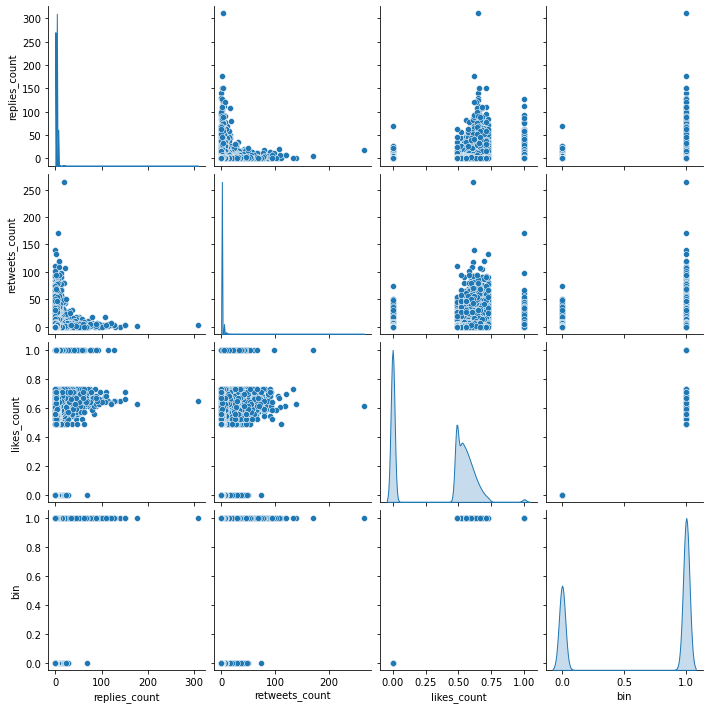

In [11]:
#sns.pairplot(train_dataset[['replies_count', 'retweets_count', 'likes_count', 'replies_count_boxcox', 'retweets_count_boxcox', 'likes_count_boxcox']], diag_kind='kde')
sns.pairplot(train_dataset[['replies_count', 'retweets_count', 'likes_count', 'bin']], diag_kind='kde')
#sns.pairplot(train_dataset[['rating', 'photos', 'replies_count', 'retweets_count', 'likes_count']], diag_kind='kde')

In [ ]:
sns.pairplot(val_dataset[['rating', 'photos', 'replies_count', 'retweets_count', 'likes_count']], diag_kind='kde')

In [ ]:
sns.pairplot(test_dataset[['rating', 'photos', 'replies_count', 'retweets_count', 'likes_count']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

In [ ]:
test_dataset.describe().transpose()

In [ ]:
val_dataset.describe().transpose()

In [28]:
def process_tweet(tweet):
    # Tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    stopwords_german = stopwords.words('german') # Perhaps remove "ich" etc. from the list?
    stopwords_file = open("stop_words_german.txt", "r")
    sws = stopwords_file.read().split("\n")
    stopwords_file.close()
    stopwords_german += sws
    no_stopwords = ['mann', 'mensch', 'menschen', 'recht', 'rechte', 'rechten', 'rechter', 'rechtes']
    additional_stopwords = ['mal', 'halt', 'sagen', 'schon', 'lassen', 'danke', 'bitte', 'einfach', 'eigentlich', 'schon', 'sich']
    stopwords_german += additional_stopwords
    stopwords_german = [x for x in stopwords_german if x not in no_stopwords]
    
    stemmer = Cistem()
    
    tweetsClean = []
    tokenizedTweet = tokenizer.tokenize(tweet)
    for word in tokenizedTweet:
        if (word not in stopwords_german):
            stem = stemmer.stem(word)
            tweetsClean.append(stem)
    
    return ' '.join(tweetsClean)

def calc_freqs(tweets, rawTweets=True):
    """
    Calculate frequencies
    
    Input:
        tweets: A list of tweets
    Output:
        freqs: A dictionary mapping each word to its frequency
    """
    freqs = {}
    for tweet in tweets:
        if(rawTweets):
            for word in tweet.split():
                if word in freqs:
                    freqs[word] += 1
                else:
                    freqs[word] = 1
        else:
            for word in process_tweet(tweet).split():
                if word in freqs:
                    freqs[word] += 1
                else:
                    freqs[word] = 1
    
    return freqs

def calc_freqs2(tweets):
    # Just as calc_freqs but used for already tokenized tweets
    freqs = {}
    for tweet in tweets:
        for word in tweet.split():
            if word in freqs:
                freqs[word] += 1
            else:
                freqs[word] = 1
    return freqs

def visualize_ratings(tweets):
    data = tweets['rating']
    plt.figure()
    #pd.plotting.autocorrelation_plot(data)
    #pd.plotting.bootstrap_plot(data, size=50, samples=500, color="grey")
    tweets.plot.scatter(x="rating", y="rating")
    

In [ ]:
visualize_ratings(tweets)

In [37]:
freqs_raw = calc_freqs(tweets_text, rawTweets=True)

In [41]:
freqs_raw["ezb"]

981

In [ ]:
stopwords_german = stopwords.words('german') # Perhaps remove "ich" etc. from the list?
stopwords_file = open("stop_words_german.txt", "r")
sws = stopwords_file.read().split("\n")
stopwords_file.close()
stopwords_german += sws
if 'mann' in stopwords_german:
    print("True")
else:
    print("False")
    
no_stopwords = ['mann', 'mensch', 'menschen', 'recht', 'rechte', 'rechten', 'rechter', 'rechtes']
additional_stopwords = ['mal', 'halt', 'sagen', 'schon', 'lassen', 'danke', 'bitte', 'einfach', 'sich']

stopwords_german += additional_stopwords

stopwords_german = [x for x in stopwords_german if x not in no_stopwords]
if 'mann' in stopwords_german:
    print("True")
else:
    print("False")

In [30]:
tweets_text = tweets['tweet'].tolist()

print("Number of tweets: ", len(tweets_text))

Number of tweets:  3093549


In [ ]:
# Remove even more stopwords...
freqs = calc_freqs(tweets_text, rawTweets=False)
freqs = sorted(freqs.items(), key=lambda x: x[1])
freqs.reverse()

In [ ]:
freqs[:10]

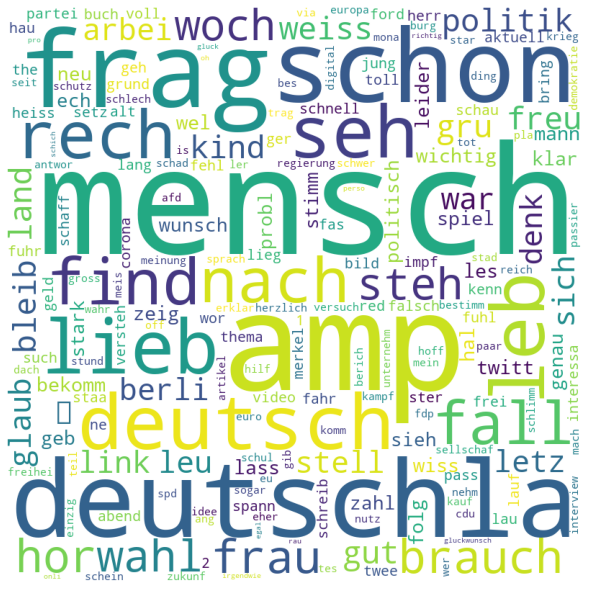

In [14]:
freqs = calc_freqs(tweets_text, rawTweets=False)
#pprint(freqs)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(freqs)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Create and train a model

Training Input: Tweets as a list of wordstems and an associated rating

Model Input: Arbitrary text (<=280 characters) which is then stemmed
Model Output: A floating point value between 0 and 1, predicting the "goodness" of the given tweet

In [15]:
# Separate label and features
train_features = train_dataset.copy()
test_features = test_dataset.copy()
val_features = val_dataset.copy()

tweets['tweet'] = tweets['tweet'].apply(process_tweet)
train_features['tweet'] = train_features['tweet'].apply(process_tweet)
test_features['tweet'] = test_features['tweet'].apply(process_tweet)
val_features['tweet'] = val_features['tweet'].apply(process_tweet)

# TODO: Add Hashtags and Cashtags to the features
#train_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)
#test_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)
#val_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)
train_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)
test_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)
val_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)

# Remove empty tweets
tweets = tweets.dropna(subset=['tweet'])
train_features = train_features.dropna(subset=['tweet'])
test_features = test_features.dropna(subset=['tweet'])
val_features = val_features.dropna(subset=['tweet'])

# Store those in a new file
tweets.to_csv('{}/preproc/tweets.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
train_features.to_csv('{}/preproc/train.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
test_features.to_csv('{}/preproc/test.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
val_features.to_csv('{}/preproc/val.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)

##train_labels = train_features.pop('rating')
##test_labels = test_features.pop('rating')
##val_labels = val_features.pop('rating')
#train_labels = train_features.pop('likes_count')
#test_labels = test_features.pop('likes_count')
#val_labels = val_features.pop('likes_count')
train_labels = train_features.pop('bin')
test_labels = test_features.pop('bin')
val_labels = val_features.pop('bin')

In [16]:
train_features

,tweet
2208866,ros ros
3062245,beeinfluss geld abhangig politik folg energie autobauerlobby schweig rustungsindustrie
1224607,jaja spass dra denk dan lug
1991280,jahresgehal setz deutschla weltmei
1509798,frau ech lauf
...,...
1450016,schon els formulartechnisch analphab versta fertig miteina per brieftaub idding zugeschick septemb dauer fri end juli
476224,schwarz magie real wissenschaf schwerkraf erfindung wakanda forev
1480126,real madrid titelgeschich autori steh applaudier
236763,ler pandemie griff bekomm


In [17]:
train_labels

2208866    0
3062245    0
1224607    0
1991280    1
1509798    1
          ..
1450016    1
476224     0
1480126    1
236763     0
1781090    0
Name: bin, Length: 2474839, dtype: int64

In [3]:
#dataset = tf.data.Dataset.from_tensor_slices(train_features.values)
#vocab_size = len(vocab)
#handle = "gecko203"
handle = "FiatPecunia"
batch_size = 32 #16 #4 #= 32
buffer_size = 10000
seed = 42
window_size = 4
embedding_dim = 0 #128 # Must be equal to the dimension of the trained embedding; is set later on
num_ns = 4 # Number of negative samples
sequence_length = 20 #10 TODO: Set to the longest tweet!

#tweets_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/tweets.csv", batch_size=batch_size,
#    label_name="rating", select_columns=['rating', 'tweet'],
#    num_epochs=1)

#train_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/train.csv", batch_size=batch_size,
#    label_name="rating", select_columns=['rating', 'tweet'],
#    num_epochs=1)
#test_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/test.csv", batch_size=batch_size,
#    label_name="rating", select_columns=['rating', 'tweet'],
#    num_epochs=1)
#val_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/val.csv", batch_size=batch_size,
#    label_name="rating", select_columns=['rating', 'tweet'],
#    num_epochs=1)

#tmp = pd.concat([pd.read_csv("preproc/train.csv", dtype={'rating': float, 'tweet': str}),
#                 pd.read_csv("preproc/test.csv", dtype={'rating': float, 'tweet': str}),
#                 pd.read_csv("preproc/val.csv", dtype={'rating': float, 'tweet': str})],
#                 ignore_index=True, sort=False)
#tmp = pd.read_csv("preproc/train.csv")
##tmp = pd.read_csv("preproc/test.csv", dtype={'rating': float, 'tweet': str})
## Remove empty tweets
#tmp = tmp.dropna(subset=['tweet'])
#tmp = tmp['tweet'].tolist()
#freqs = calc_freqs2(tmp)
#vocab = list(freqs.keys())

#tweets_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/tweets.csv", batch_size=batch_size,
#    label_name="likes_count", select_columns=['likes_count', 'tweet'],
#    num_epochs=1)

#train_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/train.csv", batch_size=batch_size,
#    label_name="likes_count", select_columns=['likes_count', 'tweet'],
#    num_epochs=1)
#test_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/test.csv", batch_size=batch_size,
#    label_name="likes_count", select_columns=['likes_count', 'tweet'],
#    num_epochs=1)
#val_dataset = tf.data.experimental.make_csv_dataset(
#    "preproc/val.csv", batch_size=batch_size,
#    label_name="likes_count", select_columns=['likes_count', 'tweet'],
#    num_epochs=1)

tweets_dataset = tf.data.experimental.make_csv_dataset(
    "{}/preproc/tweets.csv".format(handle), batch_size=batch_size,
    label_name="bin", select_columns=['bin', 'tweet'],
    num_epochs=1)

train_dataset = tf.data.experimental.make_csv_dataset(
    "{}/preproc/train.csv".format(handle), batch_size=batch_size,
    label_name="bin", select_columns=['bin', 'tweet'],
    num_epochs=1)
test_dataset = tf.data.experimental.make_csv_dataset(
    "{}/preproc/test.csv".format(handle), batch_size=batch_size,
    label_name="bin", select_columns=['bin', 'tweet'],
    num_epochs=1)
val_dataset = tf.data.experimental.make_csv_dataset(
    "{}/preproc/val.csv".format(handle), batch_size=batch_size,
    label_name="bin", select_columns=['bin', 'tweet'],
    num_epochs=1)


In [4]:
#import ast
#print(train_dataset.dtypes)
#iterator = train_dataset.as_numpy_iterator()
#print(next(iterator))
#print(ast.literal_eval(next(iterator)))
#print("----------------")
for feature_batch, label in train_dataset.take(1):
    #print("'rating': {}".format(label_batch))
    #print("features:")
    #for key, value in feature_batch.items():
    #    print("  {!r:20s}: {}".format(key, value))
    for key, value in feature_batch.items():
        print(f"{key:20s}: {value}")
    print()
    print(f"{'label':20s}: {label}")

tweet               : [b'marvi robi' b'ibmchefi rometty setz cloud' b'blockempfehlung'
 b'komisch dank' b''
 b'weiter grund cdu meid antidemokratisch einstellung erschreck sowa fraktionsvorsitz'
 b'wien polizei marschier volk'
 b'oweh anwal fahrpreisruckerstattung richterlich hilf durchbekomm'
 b'zuruckgefall' b'langzeitschad offenbar reversibel'
 b'selb schuld dach ren durchschleich stahlb amter schrubb brauch neu ausbild'
 b'prostitutio ausgeleg m\xc4\x81ori society beziehung art gastfreundschaftlich akt bzw normal extensio of hospitality with expectatio of courteou material respo betrach'
 b'bayer schau vll plakatspruch ansta punk' b'tagespress'
 b'frei arztwahl frei inter insass jva'
 b'goldgrub rock ring pfandsamml verdie festivalwoch 23000 euro'
 b'intransparenz filz vetternwirtschaf aufsichtsratsvorsitz jutta kalepky amtsvorgangeri friedrichshainkreuzberg baustadtra floria schmid gru'
 b'' b'politisch kapital jen spah politik millio'
 b'uberleg wahrscheinlichkei lieg ca 30'
 b'e

### Embedding experiments

In [5]:
emb_df = pd.read_pickle('{}/preproc/gensim_w2v_dict.pkl'.format(handle))
emb_df.head()

,word,vec
0,mensch,"[0.014191001, -0.75309145, 0.7801641, 0.077607..."
1,deutschla,"[0.05357662, -0.6997481, 0.6725014, -0.3412183..."
2,rech,"[0.061102808, -0.7291618, 1.0240439, -0.356869..."
3,frag,"[-0.1332494, -0.27263293, 0.53128016, -0.29834..."
4,schon,"[-0.2847898, 0.040354084, 0.50774884, -0.41534..."


In [6]:
print(len(emb_df["word"]))

#layer = StringLookup(vocabulary=list(emb_df["word"]))
#data = tf.constant([["frau", "deutsch", "honclbrif"]])
#layer(data)
#print(len(layer.get_vocabulary()))
#print(layer.get_vocabulary()[:3])


# Since the StringLookup-Layer prepends two new words ('' and [UNK]),
# we need to "shift" the weight matrix by two by prepending "empty" rows...
# This could lead to problems if we later try to infer on new strings containing
# word which are out of vocabulary... (?)

embedding_matrix = emb_df["vec"]
embedding_dim = len(embedding_matrix[0])
print(embedding_dim)

data = []
#data.insert(0, [])
#data.insert(0, [])
print(type(emb_df["vec"][0]))
#data.insert(0, emb_df["vec"][0])
#data.insert(0, emb_df["vec"][0])
data.insert(0, np.zeros(embedding_dim))
data.insert(0, np.zeros(embedding_dim))
embedding_matrix = pd.concat([pd.Series(data), embedding_matrix], ignore_index=True)
print(embedding_matrix.head())

#data = []
#data.insert(0, {'word': '[UNK]', 'vec': []})
#data.insert(0, {'word': '', 'vec': []})

#emb_df = pd.concat([pd.DataFrame(data), emb_df], ignore_index=True)
#print(emb_df.head())
#layer = StringLookup(vocabulary=list(emb_df["word"]))
vectorize_layer = TextVectorization(output_sequence_length=sequence_length,
                                    vocabulary=list(emb_df["word"]))

vocab_size = len(vectorize_layer.get_vocabulary())

print(vocab_size)
print(vectorize_layer.get_vocabulary()[:3])


38779
32
<class 'numpy.ndarray'>
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.014191001, -0.75309145, 0.7801641, 0.077607...
3    [0.05357662, -0.6997481, 0.6725014, -0.3412183...
4    [0.061102808, -0.7291618, 1.0240439, -0.356869...
dtype: object
38781
['', '[UNK]', 'mensch']


In [7]:
data = tf.constant(["frau man honclbrif mal"])
vectorize_layer(data)

#emb    = layers.Embedding(len(layer.get_vocabulary()), embedding_dim,
#                              embeddings_initializer=Constant(embedding_matrix),
#                              #input_length=batch_size, Deprecated?
#                              trainable=False,
#                              name="embedding")

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[  13, 5378,    1, 1888,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [8]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(len(inverse_vocab))
print(inverse_vocab[:20])

38781
['', '[UNK]', 'mensch', 'deutschla', 'rech', 'frag', 'schon', 'fall', 'seh', 'deutsch', 'find', 'wahl', 'brauch', 'frau', 'hor', 'link', 'politik', 'leb', 'weiss', 'kind']


In [43]:
# Temporarily create 3 vectorize_layers for multichannel CNN...
vectorize_layer1 = TextVectorization(output_sequence_length=sequence_length,
                                    vocabulary=list(emb_df["word"]))
#vectorize_layer2 = TextVectorization(output_sequence_length=sequence_length,
#                                    vocabulary=list(emb_df["word"]))
#vectorize_layer3 = TextVectorization(output_sequence_length=sequence_length,
#                                    vocabulary=list(emb_df["word"]))

In [9]:
def vectorize_text(text, label):
    #text = tf.expand_dims(text, -1)
    text = text['tweet']
    return vectorize_layer(text), label

In [10]:
train_dataset = train_dataset.map(vectorize_text)
test_dataset  = test_dataset.map(vectorize_text)
val_dataset   = val_dataset.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

tweets_dataset = tweets_dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Finally define and train our predictor model...

In [33]:
# In order to avoid protobuf's 2GB limit, the model needs to be split into 3 parts:
# 1) (Pre-trained) Embedding Model
# 2) (Trainable) Model
# 3) "Full" Model, connecting 1) and 2)
# Then we can skip the Embedding when saving the trained model, which should make it
# significantly smaller.
# Idea from: https://github.com/keras-team/keras/issues/4511#issuecomment-568257496

#def embedding_model(emb_matrix):
#    input1 = tf.keras.Input(shape=(1,), dtype=tf.string, name="tweet")
#    # Vectorization layer?
#    vec   = vectorize_layer1(input1)
#    emb   = layers.Embedding(vocab_size-0, embedding_dim,
#                              # Weights should be initialized after defining the model
#                              # due to protobuf's limit of 2GB:
#                              # ValueError: Message tensorflow.SavedModel exceeds maximum protobuf size of 2GB: 6768286642
#                              embeddings_initializer=Constant(list(emb_matrix)),
#                              #input_length=batch_size, Deprecated?
#                              trainable=False,
#                              name="embedding",
#                              mask_zero=True)(vec)
#    
#    return tf.keras.Model(input1, emb)

def make_model(sl=20):
    # Functional API
    inputs = tf.keras.Input(shape=(sl,), dtype=tf.int32, name="tweet")
    emb    = layers.Embedding(vocab_size-0, embedding_dim,
                              embeddings_initializer=Constant(list(embedding_matrix)),
                              #input_length=batch_size, Deprecated?
                              trainable=True,
                              name="embedding")
    #dense = layers.Dense(512, activation='relu')
    #x = dense(inputs)
    #x = vectorize_layer(inputs)
    x = inputs
    x = emb(x)
    x = layers.Dense(512, activation='relu')(x)
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.LSTM(64)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mymodel")
    
    return model

def make_classificator2():
    # Functional API
    input1 = tf.keras.Input(shape=(1,), dtype=tf.string, name="tweet")
    # Vectorization layer?
    vec1   = vectorize_layer1(input1)
    emb1   = layers.Embedding(vocab_size-0, embedding_dim,
                              # Weights should be initialized after defining the model
                              # due to protobuf's limit of 2GB:
                              # ValueError: Message tensorflow.SavedModel exceeds maximum protobuf size of 2GB: 6768286642
                              embeddings_initializer=Constant(list(embedding_matrix)),
                              #input_length=batch_size, Deprecated?
                              trainable=False,
                              name="embedding1",
                              mask_zero=True)(vec1)
    #x = layers.LSTM(1)(emb1)
    x = layers.Flatten()(emb1)
    #x = layers.Dense(4, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input1, outputs=outputs, name="mymodel")
    
    return model

def make_classificator(sl=20, output_bias=None):
    # Bias etc. from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Functional API
    #inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name="tweet")
    #emb    = layers.Embedding(vocab_size-0, embedding_dim,
    #                          embeddings_initializer=Constant(list(embedding_matrix)),
    #                          #input_length=batch_size, Deprecated?
    #                          trainable=False,
    #                          name="embedding",
    #                          mask_zero=True)
    
    #x = vectorize_layer(inputs)
    #x = emb(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.GlobalAveragePooling1D()(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Flatten()(x)
    #x = layers.Dense(16, activation='relu')(x)
    #outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Feed-Forward word2vec LSTM model
    
    #x = vectorize_layer(inputs)
    #x = emb(x)
    ###x = layers.Dropout(0.2)(x)
    ##x = layers.Bidirectional(layers.LSTM(embedding_dim*2))(x)
    ##x = layers.Dropout(0.2)(x)
    ##x = layers.Dense(2048, activation='relu', kernel_constraint=max_norm(3))(x)
    ##x = layers.Dropout(0.2)(x)
    ##x = layers.Flatten()(x)
    ##x = layers.Dropout(0.3)(x)
    ##x = layers.Dense(1024, activation='relu', kernel_constraint=max_norm(3))(x)
    ##x = layers.Dropout(0.4)(x)
    #x = layers.Bidirectional(layers.LSTM(sequence_length))(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dropout(0.5)(x)
    ##x = layers.Flatten()(x)
    ##x = layers.Dense(512, activation='relu', kernel_constraint=max_norm(3))(x)
    ##x = layers.Dropout(0.2)(x)
    #outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # DAN (Deep Average Network)
    #x = vectorize_layer(inputs)
    #x = emb(x)
    #x = layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dropout(0.3)(x)
    #outputs = layers.Dense(1, activation='softmax')(x)
    
    # Stacked LSTM
    #x = vectorize_layer(inputs)
    #x = emb(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Bidirectional((layers.LSTM(int(embedding_dim / 4), return_sequences=True)))(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.LSTM(int(embedding_dim / 2), return_sequences=True)(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.LSTM(int(embedding_dim / 2))(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dropout(0.3)(x)
    #outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Multichannel CNN (from https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)
    # 1.  Embedding: Representation of words and their similarity
    # 1.1 (LSTM directly connected to 3.?)
    # 2.  Convolutional Model: Feature extraction
    # 2.1 (LSTM?)
    # 3.  Fully Connected Model: Interpretation
    
    # Due to the embeddings' size ...... protobuf TODO
    
    # Channel1
    input1 = tf.keras.Input(shape=(sl,), dtype=tf.int32, name="tweet")
    # Vectorization layer?
    #vec1   = vectorize_layer1(input1)
    vec1   = input1
    emb1   = layers.Embedding(vocab_size-0, embedding_dim,
                              # Weights should be initialized after defining the model
                              # due to protobuf's limit of 2GB:
                              # ValueError: Message tensorflow.SavedModel exceeds maximum protobuf size of 2GB: 6768286642
                              embeddings_initializer=Constant(list(embedding_matrix)),
                              #input_length=batch_size, Deprecated?
                              trainable=False,
                              name="embedding1",
                              mask_zero=True)(vec1)
    #emb1 = tf.keras.Input(shape=(length, embedding_dim))
    #conv1 = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(emb1)
    conv1 = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(emb1)
    drop1 = layers.Dropout(0.5)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(drop1)
    lstm1 = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.0))(pool1)
    #lstm1 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(conv1)
    #flat1 = layers.Flatten()(pool1)
    flat1 = layers.Flatten()(lstm1)
    
    # Channel2
    #input2 = tf.keras.Input(shape=(1,), dtype=tf.string, name="input2")
    #vec2   = vectorize_layer2(input1)
    #emb2   = layers.Embedding(vocab_size-0, embedding_dim,
    #                          #embeddings_initializer=Constant(list(embedding_matrix)),
    #                          #input_length=batch_size, Deprecated?
    #                          trainable=False,
    #                          name="embedding2",
    #                          mask_zero=True)(vec2)
    #conv2 = layers.Conv1D(filters=32, kernel_size=6, activation='relu')(emb1)#(emb2)
    conv2 = layers.Conv1D(filters=16, kernel_size=6, activation='relu')(emb1)
    drop2 = layers.Dropout(0.5)(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(drop2)
    lstm2 = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.0))(pool2)
    #lstm2 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(conv2)
    #flat2 = layers.Flatten()(pool2)
    flat2 = layers.Flatten()(lstm2)
    
    # Channel 3
    #input3 = tf.keras.Input(shape=(1,), dtype=tf.string, name="input3")
    #vec3   = vectorize_layer3(input1)
    #emb3   = layers.Embedding(vocab_size-0, embedding_dim,
    #                          #embeddings_initializer=Constant(list(embedding_matrix)),
    #                          #input_length=batch_size, Deprecated?
    #                          trainable=False,
    #                          name="embedding3",
    #                          mask_zero=True)(vec3)
    #conv3 = layers.Conv1D(filters=32, kernel_size=8, activation='relu')(emb1)#(emb3)
    conv3 = layers.Conv1D(filters=16, kernel_size=8, activation='relu')(emb1)
    drop3 = layers.Dropout(0.5)(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(drop3)
    lstm3 = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.0))(pool3)
    #lstm3 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(conv3)
    #flat3 = layers.Flatten()(pool3)
    flat3 = layers.Flatten()(lstm3)
    
    
    # Merge
    merged = layers.concatenate([flat1, flat2, flat3])
    #merged = layers.concatenate([flat1, flat2])
    #merged = layers.concatenate([timedistributed1, timedistributed2, timedistributed3])
    #merged = flat1
    
    # Interpretation
    
    #dense1 = layers.Dense(10, activation='relu')(merged)
    dense1  = layers.Dense(256, activation='relu')(merged)
    dense1  = layers.Dense(10, activation='relu')(dense1)
    #lstm    = layers.LSTM(100)(dense1) # Bidirectional?
    #dropout = 
    outputs = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(dense1)
    #outputs = layers.Dense(1, activation='sigmoid')(lstm)
    
    
    
    #model = Model(inputs=[input1, input2, input3], outputs=outputs, name="Classificator")
    model = Model(inputs=input1, outputs=outputs, name="Classificator")
    #model = Model(inputs=emb1, outputs=outputs, name="Classificator")
    
    # Set the embeddings' weights here due to protobuf's 2GB limit.
    #emb1.set_weights(embedding_matrix.to_numpy())
    #emb2.set_weights(embedding_matrix.to_numpy())
    #emb3.set_weights(embedding_matrix.to_numpy())
    #model.layers[4].set_weights(embedding_matrix.to_numpy())
    #model.layers[5].set_weights(embedding_matrix.to_numpy())
    #model.layers[6].set_weights(embedding_matrix.to_numpy())
    #model.layers[4].set_weights(Constant(list(embedding_matrix)))
    #model.layers[5].set_weights(Constant(list(embedding_matrix)))
    #model.layers[6].set_weights(Constant(list(embedding_matrix)))
    
    
    # TODO: From paper: CNN-based, attention, hybrid, capsule
    

    #model = tf.keras.Model(inputs=inputs, outputs=outputs, name="classificator")
    
    return model

def make_classificator_nogensim(sl=20, output_bias=None):
    # Bias etc. from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    # Channel1
    input1 = tf.keras.Input(shape=(sl,), dtype=tf.int32, name="tweet")
    # Vectorization layer?
    #vec1   = vectorize_layer1(input1)
    vec1   = input1
    emb1   = layers.Embedding(vocab_size-0, 100)(vec1)
    #emb1 = tf.keras.Input(shape=(length, embedding_dim))
    #conv1 = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(emb1)
    conv1 = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(emb1)
    drop1 = layers.Dropout(0.5)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(drop1)
    lstm1 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(pool1)
    #lstm1 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(conv1)
    #flat1 = layers.Flatten()(pool1)
    flat1 = layers.Flatten()(lstm1)
    
    # Channel2
    #input2 = tf.keras.Input(shape=(1,), dtype=tf.string, name="input2")
    #vec2   = vectorize_layer2(input1)
    #emb2   = layers.Embedding(vocab_size-0, embedding_dim,
    #                          #embeddings_initializer=Constant(list(embedding_matrix)),
    #                          #input_length=batch_size, Deprecated?
    #                          trainable=False,
    #                          name="embedding2",
    #                          mask_zero=True)(vec2)
    #conv2 = layers.Conv1D(filters=32, kernel_size=6, activation='relu')(emb1)#(emb2)
    emb2  = layers.Embedding(vocab_size-0, 100)(vec1)
    conv2 = layers.Conv1D(filters=16, kernel_size=6, activation='relu')(emb2)
    drop2 = layers.Dropout(0.5)(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(drop2)
    lstm2 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(pool2)
    #lstm2 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(conv2)
    #flat2 = layers.Flatten()(pool2)
    flat2 = layers.Flatten()(lstm2)
    
    # Channel 3
    #input3 = tf.keras.Input(shape=(1,), dtype=tf.string, name="input3")
    #vec3   = vectorize_layer3(input1)
    #emb3   = layers.Embedding(vocab_size-0, embedding_dim,
    #                          #embeddings_initializer=Constant(list(embedding_matrix)),
    #                          #input_length=batch_size, Deprecated?
    #                          trainable=False,
    #                          name="embedding3",
    #                          mask_zero=True)(vec3)
    #conv3 = layers.Conv1D(filters=32, kernel_size=8, activation='relu')(emb1)#(emb3)
    emb3  = layers.Embedding(vocab_size-0, 100)(vec1)
    conv3 = layers.Conv1D(filters=16, kernel_size=8, activation='relu')(emb3)
    drop3 = layers.Dropout(0.5)(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(drop3)
    lstm3 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(pool3)
    #lstm3 = layers.Bidirectional(layers.LSTM(20, dropout=0.2, recurrent_dropout=0.0))(conv3)
    #flat3 = layers.Flatten()(pool3)
    flat3 = layers.Flatten()(lstm3)
    
    
    # Merge
    merged = layers.concatenate([flat1, flat2, flat3])
    #merged = layers.concatenate([flat1, flat2])
    #merged = layers.concatenate([timedistributed1, timedistributed2, timedistributed3])
    #merged = flat1
    
    # Interpretation
    
    #dense1 = layers.Dense(10, activation='relu')(merged)
    dense1  = layers.Dense(256, activation='relu')(merged)
    dense1  = layers.Dropout(0.2)(dense1)
    dense1  = layers.Dense(16, activation='relu')(dense1)
    dense1  = layers.Dropout(0.2)(dense1)
    #lstm    = layers.LSTM(100)(dense1) # Bidirectional?
    #dropout = 
    outputs = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(dense1)
    #outputs = layers.Dense(1, activation='sigmoid')(lstm)
    
    
    
    #model = Model(inputs=[input1, input2, input3], outputs=outputs, name="Classificator")
    model = Model(inputs=input1, outputs=outputs, name="Classificator")
    #model = Model(inputs=emb1, outputs=outputs, name="Classificator")
    
    # Set the embeddings' weights here due to protobuf's 2GB limit.
    #emb1.set_weights(embedding_matrix.to_numpy())
    #emb2.set_weights(embedding_matrix.to_numpy())
    #emb3.set_weights(embedding_matrix.to_numpy())
    #model.layers[4].set_weights(embedding_matrix.to_numpy())
    #model.layers[5].set_weights(embedding_matrix.to_numpy())
    #model.layers[6].set_weights(embedding_matrix.to_numpy())
    #model.layers[4].set_weights(Constant(list(embedding_matrix)))
    #model.layers[5].set_weights(Constant(list(embedding_matrix)))
    #model.layers[6].set_weights(Constant(list(embedding_matrix)))
    
    
    # TODO: From paper: CNN-based, attention, hybrid, capsule
    

    #model = tf.keras.Model(inputs=inputs, outputs=outputs, name="classificator")
    
    return model


    
#def tweedie_loglikelihood(y, y_hat):
#    """
#    Implements the Tweedie loss function which is better suited to extremely skewed data like ours.
#    
#    From: https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f
#    """
#    p = 2 # power hyper-parameter
#    
#    loss = - y * tf.pow(y_hat, 1 - p) / (1 - p) + \
#            tf.pow(y_hat, 2 - p) / (2 - p)
#    return tf.reduce_mean(loss)

def tweedieloss(y_true, y_pred):
    """
    From: https://datascience.stackexchange.com/a/55393
    """
    p=0.0 #1.5
    dev = 2 * (tf.pow(y_true, 2-p)/((1-p) * (2-p)) -
                   y_true * tf.pow(y_pred, 1-p)/(1-p) +
                   tf.pow(y_pred, 2-p)/(2-p))
    return tf.reduce_mean(dev)

/home/gecko20/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 0 ... 1 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Model: "Classificator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tweet (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding1 (Embedding)          (None, 20, 32)       1240992     tweet[0][0]                      
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 18, 16)       1552        embedding1[0][0]                 
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 15, 16)       3088        embedding1[0][0]                 
______________________________________________________________________________________

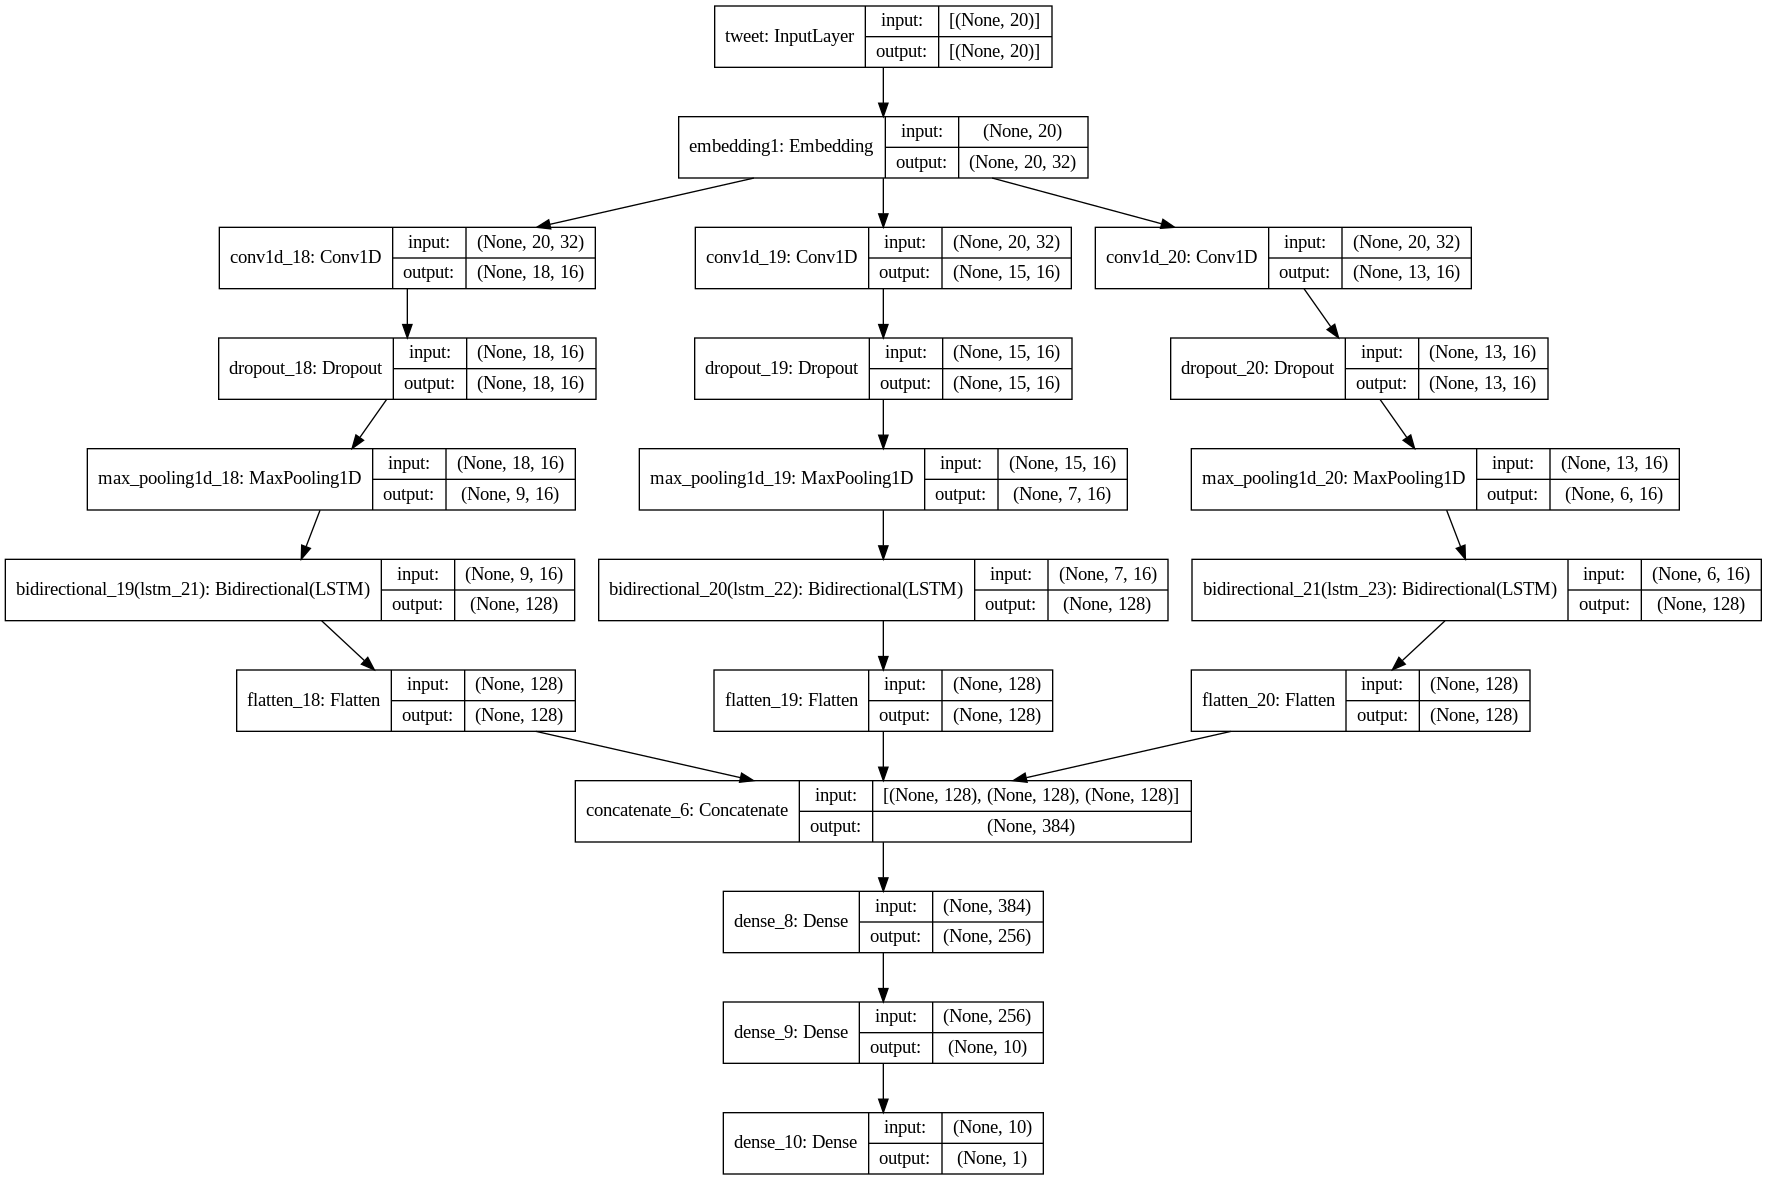

In [34]:
#print(embedding_vectors.shape[0]) # TESTME: vocab size...
#print(vocab_size)

### This model did not work - it predicted constant values for every input!

#model = Sequential([
#    layers.Input(shape=(1,), dtype=tf.string),
#    vectorize_layer,
#    #layers.Embedding(vocab_size, embedding_dim,
#    #                 name="embedding"),
#    layers.Embedding(vocab_size-1, embedding_dim,
#                     embeddings_initializer=Constant(embedding_vectors),
#                     trainable=False,
#                     name="embedding"),
#    #layers.GlobalAvgPool1D(),
#    #layers.Bidirectional(layers.LSTM(512)),
#    #layers.LSTM(64),
#    #layers.Bidirectional(layers.Dense(64)),
#    layers.Dense(64, activation='relu'),
#    #layers.Dense(64, activation='relu'),
#    layers.Dense(1)
#])

#model.compile(loss='mean_absolute_error',
#              optimizer=tf.keras.optimizers.Adam(0.001))

#sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)
#model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=sgd)

#model.summary()

#model = make_model()

#opt = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.5, nesterov=True)
##opt = tf.keras.optimizers.RMSprop(learning_rate=0.01,
##                                  rho=0.9,
##                                  momentum=0.0,
##                                  epsilon=1e-07,
##                                  centered=False)
##loss = tf.keras.losses.Huber()
##loss = tf.keras.losses.MeanSquaredError()
##loss = tf.keras.losses.MeanAbsoluteError()
##loss = tweedie_loglikelihood
#loss = tweedieloss
#model.compile(loss=loss)
#              #optimizer=opt)
#              #optimizer='adam')

#model.summary()

epochs = 20 #100
patience = int(epochs * 0.30) #int(epochs * 0.3)
learning_rate = 1e-2 * 5 #1e-4 * 5
decay_rate = learning_rate / (epochs*epochs)
momentum = 0.8

# The threshold for deciding whether prediction values are 1 or 0 should be
# the value where we have split the data into both bins.
#x_split:
#threshold = 0.2754579724298949
threshold = 0.3
#threshold = 0.5

initial_bias = [0.53100804]

#emb_model = embedding_model(embedding_matrix)
model = make_classificator(sl=sequence_length, output_bias=initial_bias)
#model = make_classificator_nogensim(sl=sequence_length, output_bias=initial_bias)
#model = make_model(sl=sequence_length)
#model = make_classificator(length=sequence_length)
#model = make_classificator2()
#full_model = Model(emb_model.input, model(emb_model.output))

# Compute class weights so that the optimizer doesn't get stuck
# in a local minimum.

labels = np.concatenate([y for x, y in train_dataset], axis=0)
classWeights = compute_class_weight('balanced', np.unique(labels), labels)
classWeights = dict(enumerate(classWeights))



METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
    tf.metrics.BinaryAccuracy(threshold=threshold)
]

#loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) # logits, ...
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#opt = tf.keras.optimizers.SGD(lr=learning_rate, decay=decay_rate, momentum=momentum, nesterov=True) #1e-5
#opt = tf.keras.optimizers.Adamax(learning_rate=1e-04, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss=loss,
              #optimizer='adam', #opt,
              optimizer=opt,
              #metrics=tf.metrics.BinaryAccuracy(threshold=threshold))
              metrics=METRICS)

model.summary()

#tf.keras.utils.plot_model(emb_model, show_shapes=True, to_file='embedding_model.png')
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
#tf.keras.utils.plot_model(full_model, show_shapes=True, to_file='full_model.png')
#tf.keras.utils.plot_model(model)

In [14]:
print(np.unique(labels))
print(classWeights)

[0 1]
{0: 1.3508680855972774, 1: 0.7938175778734367}


In [35]:
test_features = test_dataset.map(lambda x, y: x)
test_labels = test_dataset.map(lambda x, y: y)
model.predict(test_features)

array([[0.64118093],
       [0.6444519 ],
       [0.6323939 ],
       ...,
       [0.6400041 ],
       [0.6330497 ],
       [0.64406896]], dtype=float32)

In [36]:
#train_dataset = train_dataset.batch(1)
tf.autograph.set_verbosity(0)
#logging.getLogger("tensorflow").setLevel(logging.ERROR)
#early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=patience)
#early_stopping = EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=patience)
early_stopping = EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=patience)
#model_checkpoint = ModelCheckpoint('{}/models/classificator_best.tf'.format(handle),
model_checkpoint = ModelCheckpoint('{}/models/classificator_best.tf'.format(handle),
                                   monitor='val_binary_accuracy', 
                                   #monitor='val_precision',
                                   save_format='tf',
                                   #save_format='h5', 
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)



#multi_input_ds = tf.data.Dataset.zip((train_dataset, train_dataset, train_dataset))

#print(multi_input_ds.element_spec)

# number_of_train_samples / batch_size
#steps_per_epoch = 154676 // batch_size
#                  3093549
#steps_per_epoch = 3093549 // batch_size
#epochs=3
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    #batch_size=1,
    #class_weight=classWeights, # ValueError: `class_weight` is only supported for Models with a single output.
    class_weight=classWeights,
    callbacks=[early_stopping, model_checkpoint],
    #steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Epoch 1/20
11710/11710 [==============================] - 131s 11ms/step - loss: 0.6628 - tp: 58387.0389 - fp: 20866.9041 - tn: 48357.0851 - fn: 59780.9692 - precision: 0.7325 - recall: 0.4950 - auc: 0.6293 - prc: 0.7401 - binary_accuracy: 0.6409 - val_loss: 0.6401 - val_tp: 16301.0000 - val_fp: 5810.0000 - val_tn: 11720.0000 - val_fn: 13009.0000 - val_precision: 0.7372 - val_recall: 0.5562 - val_auc: 0.6583 - val_prc: 0.7549 - val_binary_accuracy: 0.6398

Epoch 00001: val_binary_accuracy improved from -inf to 0.63982, saving model to FiatPecunia/models/classificator_best.tf
Epoch 2/20
11710/11710 [==============================] - 116s 10ms/step - loss: 0.6537 - tp: 61016.5614 - fp: 21225.1160 - tn: 47998.8732 - fn: 57151.4467 - precision: 0.7408 - recall: 0.5158 - auc: 0.6495 - prc: 0.7538 - binary_accuracy: 0.6477 - val_loss: 0.6354 - val_tp: 17145.0000 - val_fp: 6242.0000 - val_tn: 11288.0000 - val_fn: 12165.0000 - val_precision: 0.7331 - val_recall: 0.5850 - val_auc: 0.6628 - val_

In [ ]:
saved_model = load_model('{}/models/classificator_best.tf'.format(handle))

_, train_acc = saved_model.evaluate(train_dataset, verbose=1)
_, test_acc  = saved_model.evaluate(test_dataset, verbose=1)

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

In [ ]:
def plot_loss(hist):
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.ylim([0, .3])
    plt.xlabel=('Epoch')
    plt.ylabel=('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

## Run the model on some new tweets.

In [ ]:
for feature_batch, label in test_dataset.take(1):
    for key, value in feature_batch.items():
        print(f"{key:20s}: {value}")
    print()
    print(f"{'label':20s}: {label}")

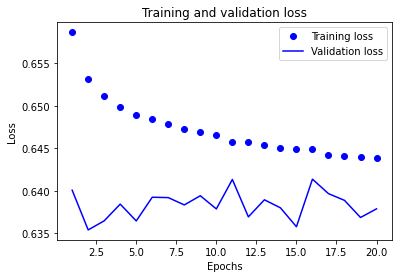

In [37]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_ = range(1, len(acc) + 1)

plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

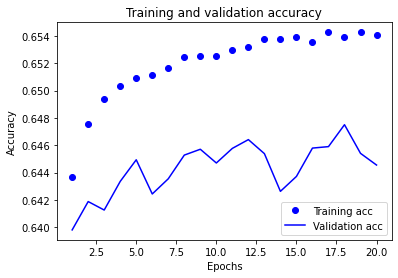

In [38]:
plt.plot(epochs_, acc, 'bo', label='Training acc')
plt.plot(epochs_, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

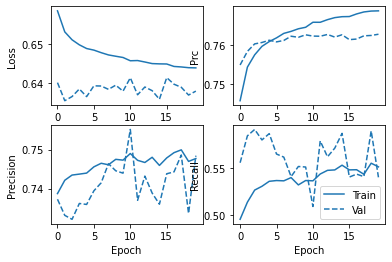

In [39]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
              #plt.ylim([0, plt.ylim()[1]])
                print("")
        elif metric == 'auc':
              plt.ylim([0.8,1])
        else:
              #plt.ylim([0,1])
            print("")

    plt.legend()
    
plot_metrics(history)

1464/1464 [==============================] - 9s 6ms/step - loss: 0.6395 - tp: 15986.0000 - fp: 5371.0000 - tn: 11843.0000 - fn: 13640.0000 - precision: 0.7485 - recall: 0.5396 - auc: 0.6610 - prc: 0.7654 - binary_accuracy: 0.6490
[0.6394997835159302, 15986.0, 5371.0, 11843.0, 13640.0, 0.7485133409500122, 0.5395935773849487, 0.660981297492981, 0.7653892040252686, 0.6489965915679932]
       0
0      0
1      0
2      0
3      1
4      0
...   ..
46835  1
46836  1
46837  0
46838  1
46839  1

[46840 rows x 1 columns]
[[0.38113216]
 [0.5537471 ]
 [0.40115675]
 ...
 [0.44086045]
 [0.53100246]
 [0.4585696 ]]
loss :  0.6394997835159302
tp :  15986.0
fp :  5371.0
tn :  11843.0
fn :  13640.0
precision :  0.7485133409500122
recall :  0.5395935773849487
auc :  0.660981297492981
prc :  0.7653892040252686
binary_accuracy :  0.6489965915679932

True Negatives:  1089
False Positives:  16125
False Negatives:  316
True Positives:  29310
Total:  29626


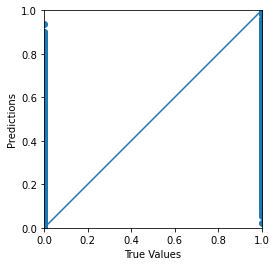

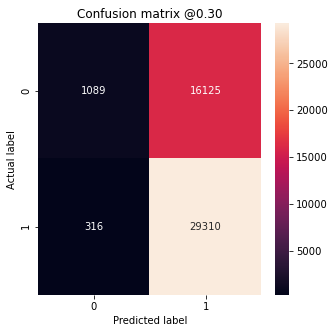

In [40]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

# TODO
test_results = model.evaluate(
    test_dataset
)
print(test_results)

test_features = test_dataset.map(lambda x, y: x)
test_labels = test_dataset.map(lambda x, y: y)
test_predictions = model.predict(test_features)

#print(test_labels)

ex = test_labels.unbatch()
# ex = next(iter(test_labels))
ex = pd.DataFrame(ex)
print(ex)
print(test_predictions)

train_features = train_dataset.map(lambda x, y: x)
train_labels = train_dataset.map(lambda x, y: y)
ex2 = train_labels.unbatch()
ex2 = pd.DataFrame(ex2)
train_predictions = model.predict(train_features)
#print(len(test_predictions))
#
#for label_batch in test_labels.take(1):
#    print(label_batch)
#print(test_predictions)


a = plt.axes(aspect='equal')
plt.scatter(ex, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

for name, value in zip(model.metrics_names, test_results):
    print(name, ': ', value)
print()


#test_features = tfds.as_numpy(test_features.unbatch())
#test_labels = tfds.as_numpy(test_labels.unbatch())
plot_cm(ex, test_predictions, p=threshold)

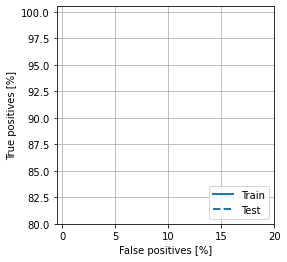

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_roc("Train", ex2, train_predictions, color=colors[0])
plot_roc("Test", ex, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right')